In [1]:
!python --version

Python 3.10.11


In [1]:
import torch
import numpy as np
import pandas as pd

In [4]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [106]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
model.cuda()

def get_embs(text):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embs = model_output.last_hidden_state[:, 0, :]
    embs = torch.nn.functional.normalize(embs)
    return embs[0].cpu().numpy()

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
get_embs('hi').shape

(312,)

In [112]:
def distance(embeddings1, embeddings2, distance_metric=0):
    if distance_metric==0:# Euclidian
        diff = np.subtract(embeddings1, embeddings2)
        dist = np.sum(np.square(diff),0)
    elif distance_metric==1:#cosine
        dot = np.sum(np.multiply(embeddings1, embeddings2), axis=0)
        norm = np.linalg.norm(embeddings1, axis=0) * np.linalg.norm(embeddings2, axis=0)
        similarity = dot / norm
        dist = np.arccos(similarity) / np.pi
    else:
        raise 'Undefined %d' % distance_metric
    return dist

def get_distance(id1, id2, metric=1):
    label1 = df['label'][id1] if type(id1) == int else str(id1)
    label2 = df['label'][id2] if type(id2) == int else str(id2)
    print(f'distance between {label1} and {label2}: {distance(get_embs(label1), get_embs(label2), distance_metric=metric)}')

In [114]:
distance(get_embs('привет'), get_embs('здравствуйте'))

0.22765881

In [8]:
df = pd.read_csv("C:\\Users\\yeril\\Desktop\\111.csv", sep=';', names=['id', 'label'])
df.head()

,id,label
0,304999800,"ПРОЧЕЕ МЯСО РЫБЫ (ВКЛЮЧАЯ ФАРШ), МОРОЖЕНЫЕ, РЫ..."
1,604909900,"РАСТЕНИЯ ЗАСУШЕННЫЕ, ОБРАБОТАННЫЕ АНТИСЕПТИКОМ..."
2,711400000,ОГУРЦЫ (КОРНИШОНЫ) КОНСЕРВИРОВАННЫЕ ДЛЯ КРАТКО...
3,712909000,"ОВОЩИ СУЩЕННЫЕ, ЧЕСНОК СУШЕННЫЙ ХЛОПЬЯ, МАРКИР..."
4,803901000,"БАНАНЫ СВЕЖИЕ, ЗЕЛЕНЫЕ, СОРТА ""CAVENDISH"", УПА..."


In [9]:
df['label'] = df['label'].str.lower()
df['label'] = df['label'].str.strip()
df['label'] = df['label'].str.replace(r'\s+', ' ')
df['label'] = df['label'].str.replace(r'[^\w\s]+', ' ')

C:\Users\yeril\AppData\Local\Temp\ipykernel_7820\970123699.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['label'] = df['label'].str.replace(r'\s+', ' ')
C:\Users\yeril\AppData\Local\Temp\ipykernel_7820\970123699.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['label'] = df['label'].str.replace(r'[^\w\s]+', ' ')


In [10]:
len(df['id'].unique())

2610

In [11]:
len(df['label'].unique())

69218

In [12]:
df = df.drop_duplicates()

In [44]:
len(df)

69958

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69958 entries, 0 to 70588
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      69958 non-null  int64 
 1   label   69958 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.6+ MB


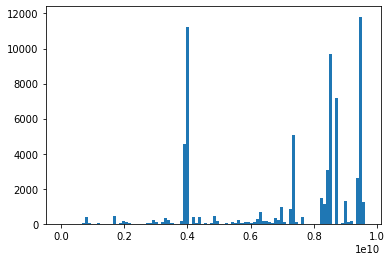

In [14]:
from matplotlib import pyplot as plt 
plt.hist(df['id'], 100)
plt.show()

In [16]:
from tqdm import tqdm
embs = []
for i, label in enumerate(tqdm(df['label'])):
    embs.append(get_embs(label))
len(embs)

100%|███████████████████████████████████████████████████████████████████████████| 69958/69958 [05:07<00:00, 227.27it/s]


69958

In [18]:
df['emb'] = embs

In [19]:
df

,id,label,emb
0,304999800,прочее мясо рыбы включая фарш мороженые рыб...,"[0.02312238, -0.047608964, -0.026546676, -0.04..."
1,604909900,растения засушенные обработанные антисептиком...,"[0.07274635, -0.06827808, 0.034841597, -0.1009..."
2,711400000,огурцы корнишоны консервированные для кратко...,"[-0.02142443, -0.045624927, 0.02732854, -0.094..."
3,712909000,овощи сущенные чеснок сушенный хлопья маркир...,"[0.059772942, -0.03212928, 0.040867265, -0.100..."
4,803901000,бананы свежие зеленые сорта cavendish упак...,"[0.015860813, -0.07562457, 0.012571128, -0.070..."
...,...,...,...
70584,9617000001,термосы и вакуумные сосуды прочие в собранном ...,"[-0.0034721876, 0.017499765, 0.04958394, -0.09..."
70585,9617000001,термосы и вакуумные сосуды прочие в собранном ...,"[0.037946466, -0.0316441, 0.02204541, -0.08155..."
70586,9619008109,детские подгузники baby diaspers,"[0.07619122, -0.03667876, 0.04221478, -0.06858..."
70587,9620000005,моноопоры двуноги треноги и аналогичные издели...,"[0.0155068915, 0.00056217174, -0.005092197, -0..."


In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [23]:
y = df['id'].values
X = embs

In [29]:
from sklearn.model_selection import GridSearchCV, cross_val_score

knn_grid = {'n_neighbors': np.array(np.linspace(3, 7, 5), dtype='int')}
gs = GridSearchCV(knn, knn_grid, cv=5, n_jobs=-1)
gs.fit(X, y)

C:\Users\yeril\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([3, 4, 5, 6, 7])})

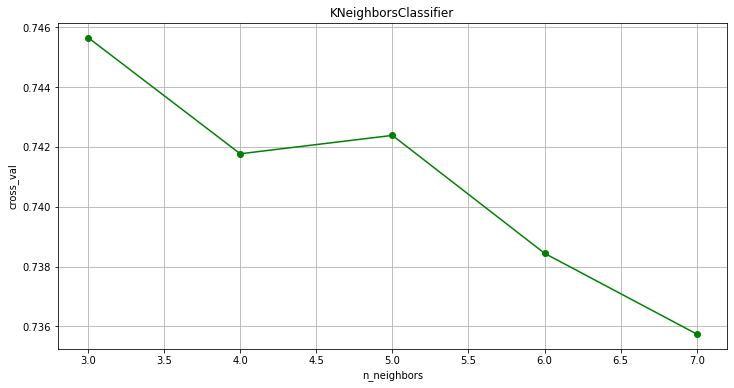

In [30]:
def grid_plot(x, y, x_label, title, y_label='cross_val'):
    plt.figure(figsize=(12, 6))
    plt.grid(True)
    plt.plot(x, y, 'go-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    
grid_plot(knn_grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

In [32]:
knn = KNeighborsClassifier(n_neighbors=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
knn.fit(X_train, y_train)
preds = knn.predict(X_test)
accuracy_score(y_test, preds)

0.7338479130931961

In [46]:
#knn.predict(get_embs('Прессы для упаковки в кипы соломы и сена').reshape(312))
X[1].shape

(312,)

In [48]:
get_embs('Прессы для упаковки в кипы соломы и сена').reshape(1, 312).shape

(1, 312)

In [120]:
knn.predict(get_embs('гайка').reshape(1, 312))

array(['4009'], dtype='<U4')

In [77]:
g_id = []
for i, id in enumerate(tqdm(df['id'])):
    g_id.append(str(id)[:4])
g_id[:10]

100%|███████████████████████████████████████████████████████████████████████| 69958/69958 [00:00<00:00, 1554677.25it/s]


['3049',
 '6049',
 '7114',
 '7129',
 '8039',
 '8039',
 '8039',
 '8039',
 '8039',
 '8045']

In [78]:
df['g_id'] = g_id

In [79]:
knn = KNeighborsClassifier(n_neighbors=3)
X_train, X_test, y_train, y_test = train_test_split(X, g_id, test_size=0.3)
knn.fit(X_train, y_train)
preds = knn.predict(X_test)
accuracy_score(y_test, preds)

0.8523918429578807

In [82]:
knn.predict(get_embs('ОГУРЦЫ (КОРНИШОНЫ) КОНСЕРВИРОВАННЫЕ').reshape(1, 312))

array(['7318'], dtype='<U4')

In [115]:
df['label'][2]

'огурцы  корнишоны  консервированные для кратковременного хранения в рассоле'

In [117]:
distance(get_embs(df['label'][2]), get_embs('огурцы'))

0.83648443

In [119]:
distance(get_embs(df['label'][2]), get_embs('шины'))

1.0503073